# Gradient

In [1]:
from collections import namedtuple
from IPython.display import display

import numpy as np


import matplotlib.pyplot as plt

import source.tensorize as t
import torch.optim as optim 
import torch.nn.functional as F
from source.scene import *
from source.renderer import *

%load_ext autoreload
%autoreload 2

### Ground Truth and Initial Guess

Remember the trainable quantities are the scene parameters.  

In [2]:
experiment = 'gradient_test_1'
true_scene = parse_scene('./scenes/%s.ground_truth.yaml' % experiment)
pred_scene = parse_scene('./scenes/%s.init1.yaml' % experiment)


Now create the images and display the initialization:

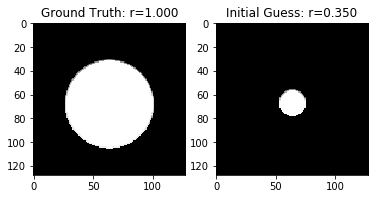

In [3]:
true_renderer = FlatRenderer(true_scene)
true_image = true_renderer.forward()
true_image.show_image('albedo', title='Ground Truth: r=%.3f'% true_scene['ball_1'].radius, subplot='121')

pred_renderer = FlatRenderer(pred_scene)
pred_renderer.set_trainable({'ball_1': ['radius']})
pred_image = pred_renderer.forward()
radius = t.detach_numpy(pred_renderer.ball_1['radius'])
pred_image.show_image('albedo', title='Initial Guess: r=%.3f' % radius, subplot='122')
plt.show()

Soft penalty regularizer with temperature $\tau > 0$:
$$p_\tau(r) = \tau \log(1 + \exp( -\frac{r}\tau )) 
\quad
\overset {\tau\rightarrow 0}\rightarrow 
\quad
- \min(r, 0) $$
Ensures $r > 0$ but has gradient everywhere compared to limit which is ReLU penalty. 

In [4]:
def soft_penalty(r, tau=.1):
    penalty = tau * t.log(1 + t.exp(-r / tau))
    return penalty

In [5]:
params  = filter(lambda p: p.requires_grad, pred_renderer.parameters())
optimizer = optim.SGD(params, lr=.01)

Use L2-image difference with smooth regularizer as loss:   
$$
\mathcal L(y, \hat y)
= \frac1 {WH} \| y- \hat y\|_{2} + p_{\tau}(r)
$$

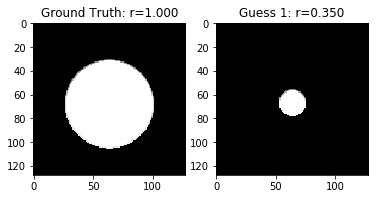

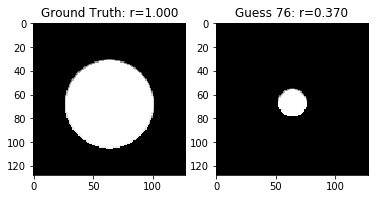

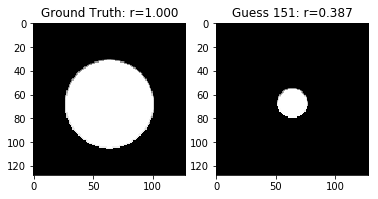

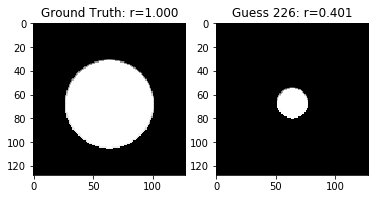

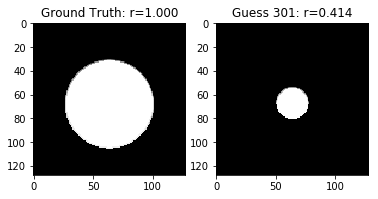

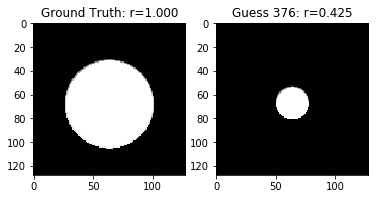

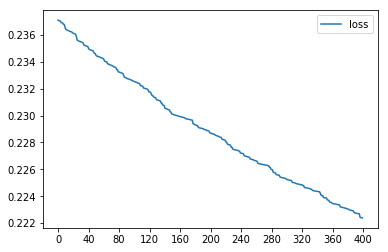

In [6]:
iterations = 400
loss_history = []
for _ in range(iterations):
    
    pred_renderer.clear()
    optimizer.zero_grad()
    
    pred_image = pred_renderer.forward()
    r = pred_renderer.ball_1['radius']
    loss = F.mse_loss(true_image.get_image('albedo'), pred_image.get_image('albedo'))
    loss = loss + soft_penalty(r)
    loss.backward()
    optimizer.step()

    
    #history of intermediate losses and images 
    loss_history.append(t.detach_numpy(loss))
    
    if _ % 75 == 0:
        true_image.show_image('albedo', title='Ground Truth: r=%.3f'% true_scene['ball_1'].radius, subplot='121')
        radius = pred_renderer.ball_1['radius'].detach().cpu().numpy()
        pred_image.show_image('albedo', title='Guess %d: r=%.3f' % (_+1,radius), subplot='122')
        plt.show()
    
    
_ = np.arange(iterations)
plt.plot(_, loss_history, label='loss')
plt.xticks(np.arange(0,iterations+1,iterations//10))
plt.legend()
plt.show()


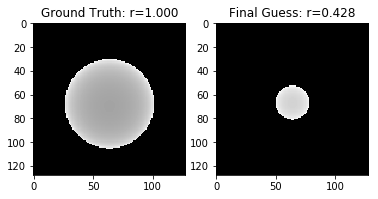

In [7]:
true_image.show_image(title='Ground Truth: r=%.3f'% true_scene['ball_1'].radius, subplot='121')
radius = pred_renderer.ball_1['radius'].detach().cpu().numpy()
pred_image.show_image(title='Final Guess: r=%.3f' % radius, subplot='122')
plt.show()
